<a href="https://colab.research.google.com/github/conorlime/CS6271/blob/main/GP%20With%20NSGA%20II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of NSGA II using GP

In this notebook we use GP with NSGA II as its selection method. Recall that NSGA II can be used with virtually **any** EA, despite what its name might suggest.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Install DEAP. 

In [3]:
!pip install deap==1.3

     |████████████████████████████████| 152 kB 5.1 MB/s 


Mount our folder.

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone the class repository. 

In [6]:
!git clone https://github.com/conorlime/CS6271

Cloning into 'CS6271'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 167 (delta 65), reused 16 (delta 1), pack-reused 0
Receiving objects: 100% (167/167), 2.83 MiB | 8.59 MiB/s, done.
Resolving deltas: 100% (65/65), done.


Navigate to the Utilities folder.

In [7]:
cd CS6271/Utilities/

/content/CS6271/Utilities


Import our tools. 

In [8]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import csv

from elitism import eaSimpleWithElitism 


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.

In [9]:
# Genetic Programming constants:
POPULATION_SIZE = 200
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10

N_RUNS = 2




Set the random seed. 

In [10]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

GP-Specific constants.

In [11]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Read in the data.

In [13]:
with open("../data/randomData.csv") as symbRegData:
    n_rows = sum(1 for line in symbRegData)
with open("../data/randomData.csv") as symbRegData:
    reader = csv.reader(symbRegData)
    data = list(list(float(elem) for elem in row) for row in reader)

Define our fitness function.

In [14]:
def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the sum of squared difference between the expression and the target values
    diff = sum((func(*row[:-1]) - row[-1])**2 for row in data)
    error = diff/n_rows
    if (error>10):
        error=10
    #return error, individual.height
    nodes, edges, labels = gp.graph(individual)
    return error, len(nodes)

Define a protected division function.

In [15]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

Add our functions and terminals. 

In [16]:
pset = gp.PrimitiveSet("MAIN", 5) # number of inputs!!!
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.random())


Create our toolbox. This is very similar to earlier ones except we now use NSGA II as our selection method.

In [17]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selNSGA2)
#toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Create our statistics. These are a bit more complex than the GA ones because we want to keep track of fitness and size for all runs.

In [18]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []
maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

Main run -- notice that we are use **eaSimple** here, although the code to run with Elitism is there too. Try each of them and see if you can figure out why the results are different (or, if they're the same, why is that the case?).



Currently on run 0 of 2
-- Best Individual =  add(ARG0, mul(0.513147606892361, ARG4))
-- length=5, height=2
-- Best Fitness =  0.07570267643521089


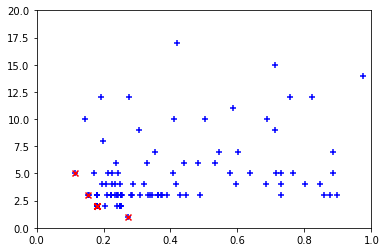



Currently on run 1 of 2
-- Best Individual =  add(ARG0, mul(0.569463821124054, ARG2))
-- length=5, height=2
-- Best Fitness =  0.07438237907562678


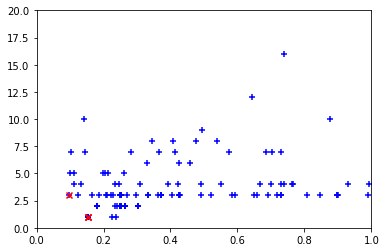

In [19]:
for r in range(0, N_RUNS):
    population = toolbox.population(n=POPULATION_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


    # Create our statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    
    

    # It's usually a good idea to turn off verbose when conducting multiple runs
    population, logbook = algorithms.eaSimple(population,toolbox,cxpb=P_CROSSOVER,mutpb=P_MUTATION,ngen=MAX_GENERATIONS,stats=mstats,halloffame=hof,verbose=False)
    
    # It's usually a good idea to turn off verbose when conducting multiple runs
    #population, logbook = eaSimpleWithElitism(population,toolbox,cxpb=P_CROSSOVER,mutpb=P_MUTATION,ngen=MAX_GENERATIONS,stats=mstats,halloffame=hof,verbose=False)


    
    # Calculate the fronts
    fronts = tools.emo.sortLogNondominated(population, len(population))

    
    #maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
    meanFitnessValues, stdFitnessValues, minFitnessValues, maxFitnessValues  = logbook.chapters['fitness'].select("avg", "std", "min", "max")
    meanSizeValues, stdSizeValues, minSizeValues, maxSizeValues  = logbook.chapters['size'].select("avg", "std", "min", "max")


    # Save statistics for this run:
    avgListFitness.append(meanFitnessValues)
    stdListFitness.append(stdFitnessValues)
    minListFitness.append(minFitnessValues)
    maxListFitness.append(maxFitnessValues)
    
    avgListSize.append(meanSizeValues)
    stdListSize.append(stdSizeValues)
    minListSize.append(minSizeValues)
    maxListSize.append(maxSizeValues)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])

    x = list(ind.fitness.values[0] for ind in population)
    y = list(ind.fitness.values[1] for ind in population)
    plt.xlim(0, 1)
    plt.ylim(0, 20)
    plt.scatter(x, y, marker="+", color='blue')
    x = list(ind.fitness.values[0] for ind in fronts[0])
    y = list(ind.fitness.values[1] for ind in fronts[0])
    plt.scatter(x, y, marker="x", color='red')
    plt.show()


Create our graphs using the averages across all the runs. Notice how we use standard deviation to show how much variation there is in the runs. 

Notice that if there's a big discrepancy between best and average the graphs can look like there's virtually no variation in the best score. If this happens, the first thing to do is verify if that is actually happening; you can do that by commenting out this line:

**plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")**

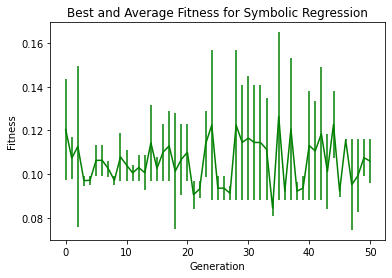

In [20]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListFitness)
stdArray = numpy.array(stdListFitness)
minArray = numpy.array(minListFitness)
maxArray = numpy.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best and Average Fitness for Symbolic Regression')
#plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
plt.show()